# RNN
## Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

In [1]:
#load the packages
from __future__ import unicode_literals, print_function, division
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


# Read text dataset

In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(all_categories[:])



['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


# Create dataset

In [3]:
X = []
y = []

for c in all_categories:
    for n in range(len(category_lines[c])):
        X.append(category_lines[c][n])
        y.append(c)

20074
20074
Hello


# Train Test split

In [4]:
#split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

In [5]:

#count
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  16059
The number of observations in the test data:  4015


## Creat batch for name and langugae

In [6]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

#function to print the output
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('')
        else:
            index = t.argmax()
            print(all_letters[index])
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [7]:
n_points = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# RNN model

In [8]:
#create simple rnn network 
class RNN(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

## Dataloader

In [9]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    
    return to_ret
#function to create representation of the name
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep
#function to create vec representation of the language
def lang_rep(lang):
    return torch.tensor([all_categories.index(lang)], dtype = torch.long)

## Evaluation function

In [10]:
#create an evaluation function 

def eval(net, n_points, topk, X_, y_, device = "cpu"):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

## Training Function

In [11]:
def train_batch(net, opt, criterion, n_points, device):
    net.train().to(device)
    opt.zero_grad()
    batch_input, batch_groundtruth = batched_dataloader(n_points, X, y, False, device)
    output, hidden = net(batch_input)
    loss = criterion(output, batch_groundtruth)
    loss.backward()
    opt.step()

    return loss

In [12]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device='cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

In [13]:
n_hidden = 128 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)



In [14]:
def infer(net, name, device = "cpu"):
    name_ohe = name_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

# Result

Iteration 4999 Loss 0.45493385195732117


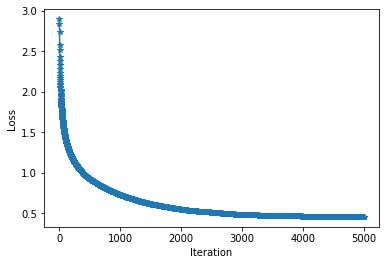




Top-1 Accuracy: 0.8084682440846824 Top-2 Accuracy: 0.9202988792029888


In [15]:
from IPython.display import clear_output
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500,device=device)

The result showed that loss steadily decease which is 0.4549 with 5000 iteration. For accuracy, we use test set and result showed that top-1 accuracy is 0.80 and top-2 accuracy is 0.92.